# Cosmological Power Spectrum Analysis with Multi-Agent System 

**Architecture:**
- **Data Agent**: Loads observational data
- **Modeling Agent**: Handles cosmology models and P(k) computations  
- **Viz Agent**: Creates visualizations and comparisons
- **Orchestrator Agent**: Coordinates all agents to complete user queries

## Setup and Installation

In [1]:
# Python 3.12 

import sys
import subprocess

packages = ['python-dotenv', 'smolagents', 'numpy', 'scipy', 'matplotlib', 'classy']
for package in packages:
    try:
        __import__(package)
        print(f"{package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"{package} installed successfully")

smolagents already installed
numpy already installed
scipy already installed
matplotlib already installed
classy already installed


In [3]:
# Output directory for agents to store their files
import os

AGENTS_OUT_DIR = 'agent-output'
os.makedirs(AGENTS_OUT_DIR, exist_ok=True)

In [4]:
# Get your Gemini API key from: https://aistudio.google.com/app/apikey"
# Save your key to a .env file saved to the root directory

from dotenv import load_dotenv

load_dotenv()
google_api_key = os.getenv('GOOGLE_API_KEY')

## Tools

These wrappers simply expose existing functions as smolagent tools. **All original functions in `codes/` remain completely unmodified.**

In [5]:
from smolagents import tool

### Data Tools
Wrapper for: codes.data.load_observational_data()

In [6]:
import numpy as np

@tool
def create_theory_k_grid() -> object:
    """
    Create standard k-grid for theoretical power spectrum predictions.
    
    ALWAYS CALL THIS FIRST before computing any theoretical models!
    
    This creates a 300-point logarithmic k-grid from 0.0001 to 10 h/Mpc, matching
    the k-grid used in demo.ipynb. ALL theoretical models must use this same k-grid
    for consistency and proper visualization across the full x-axis range.
    
    DO NOT use observational k-bins (which only cover ~0.2 to 2.5 h/Mpc with 19 points)
    for computing theoretical models. Observational k-bins are only for plotting
    observational data points, not for theoretical predictions.
    
    Returns:
        Numpy array of k values in h/Mpc (300 points, 0.0001 to 10 h/Mpc)
        
    Example workflow:
        k_theory = create_theory_k_grid()  # ← Do this FIRST!
        model_results = compute_all_models(k_theory)  # ← Use this for models
    """
    k_theory = np.logspace(-4, np.log10(10), 300)
    print(f"Created theory k-grid: {len(k_theory)} points, range [{k_theory.min():.2e}, {k_theory.max():.2e}] h/Mpc")
    return k_theory

In [7]:
@tool
def load_observational_data(filepath: str) -> tuple:
    """
    Load observational data from text file.
    
    Args:
        filepath: Path to the data file
    
    Returns:
        Tuple of (k, P(k), error) arrays or (None, None, None) if loading fails
    """
    from codes.data import load_observational_data as load_obs_data
    return load_obs_data(filepath)

### Cosmology Model Tools
Wrappers for: codes.cosmology_models.* 

In [8]:
@tool
def LCDM() -> dict:
    """
    Flat ΛCDM baseline (cold dark matter + cosmological constant).

    The standard 6-parameter cosmological model with cold dark matter and
    cosmological constant dark energy (w = -1).

    Papers:
        - CLASS code: https://arxiv.org/abs/1104.2933
        - Planck 2018 params: https://arxiv.org/abs/1807.06209
    """
    from codes.cosmology_models import LCDM as LCDM_model
    return LCDM_model()

@tool
def nu_mass(sum_mnu_eV: float = 0.10, N_species: int = 1) -> dict:
    """
    ΛCDM + massive neutrinos.

    Adds massive neutrinos implemented as non-cold dark matter (ncdm) species.
    Massive neutrinos suppress small-scale power via free-streaming. The total
    neutrino mass is split equally among N_species degenerate mass eigenstates.

    Args:
        sum_mnu_eV: Total neutrino mass in eV (default: 0.1 eV)
        N_species: Number of massive neutrino species (default: 1)

    Returns:
        Dictionary of CLASS parameters for this model

    IMPORTANT: When creating model_results dictionaries for visualization, use the
    FULL descriptive name as the key: 'ΛCDM + Σmν=0.10 eV' (not 'Massive Neutrinos')
    This ensures proper color coding and line styles in plots.

    Papers:
        - Lesgourgues & Pastor review: https://arxiv.org/abs/1212.6154
        - Planck 2018 neutrino constraints: https://arxiv.org/abs/1807.06209
    """
    from codes.cosmology_models import nu_mass as nu_mass_model
    return nu_mass_model(sum_mnu_eV, N_species)

@tool
def wCDM(w0: float = -0.9) -> dict:
    """
    Dark energy with constant equation of state parameter w0.

    Constant dark energy equation of state w = w0 (here w0 ≈ -0.9).
    This alters late-time growth and distance relations compared to ΛCDM (w = -1).

    Args:
        w0: Dark energy equation of state (default: -0.9)

    Returns:
        Dictionary of CLASS parameters for this model

    IMPORTANT: When creating model_results dictionaries for visualization, use the
    FULL descriptive name as the key: 'wCDM (w0=-0.9)' (not 'wCDM')
    This ensures proper color coding and line styles in plots.

    Papers:
        - Chevallier-Polarski parametrization: https://arxiv.org/abs/gr-qc/0009008
        - Linder review: https://arxiv.org/abs/astro-ph/0208512

    Note: Returns a dict with special '_w0_approx' key for post-processing if CLASS
          doesn't support fluid dark energy.
    """
    from codes.cosmology_models import wCDM as wCDM_model
    return wCDM_model(w0)

### Analysis Tools
Wrappers for: codes.analysis.*

In [9]:
@tool
def compute_power_spectrum(params: dict, k_values: object) -> object:
    """
    Compute power spectrum for given cosmological parameters.

    IMPORTANT: Always call create_theory_k_grid() FIRST to get the proper k-grid,
    then pass that k-grid as k_values to this function. Do NOT use observational
    k-bins for theoretical model computations.

    Args:
        params: Dictionary of cosmological parameters
        k_values: Array of k values to compute P(k). Should be the theory k-grid
                 from create_theory_k_grid() (300 points, 0.0001 to 10 h/Mpc),
                 NOT the observational k-bins.

    Returns:
        Array of P(k) values or None if computation fails
    """
    from codes.analysis import compute_power_spectrum as compute_pk
    return compute_pk(params, k_values)

@tool
def compute_all_models(k_values: object, models: dict = None) -> dict:
    """
    Compute power spectra for all defined models.

    CRITICAL WORKFLOW:
    1. ALWAYS call create_theory_k_grid() FIRST to get the theory k-grid
    2. Pass that k-grid to this function as k_values
    3. Do NOT use observational k-bins for theoretical models
    
    RECOMMENDED: Call this function WITHOUT the models argument to automatically compute
    all standard models with properly formatted names for visualization.

    Args:
        k_values: Array of k values in h/Mpc. Should be the theory k-grid from
                 create_theory_k_grid() (300 points, 0.0001 to 10 h/Mpc),
                 NOT the observational k-bins (only 19 points, 0.2 to 2.5 h/Mpc).
        models: Optional dictionary of models. If None (RECOMMENDED), uses define_cosmology_models()
                which returns models with correct names for visualization.

    Returns:
        Dictionary with model names as keys and P(k) arrays as values

    CRITICAL - Model Naming Convention:
    If you pass a custom models dictionary, you MUST use these EXACT names as keys:
        ✓ CORRECT: 'ΛCDM', 'ΛCDM + Σmν=0.10 eV', 'wCDM (w0=-0.9)'
        ✗ WRONG:   'lcdm', 'Massive Neutrinos', 'wCDM', 'dark_energy'

    Why this matters: The visualization code has predefined colors and line styles for
    specific model names. Using incorrect names causes all models to appear gray with
    identical line styles, making them visually indistinguishable in plots.

    Example (CORRECT USAGE):
        k_theory = create_theory_k_grid()  # ← ALWAYS do this first!
        model_results = compute_all_models(k_theory)  # ← Use theory grid, not obs bins
    """
    from codes.analysis import compute_all_models as compute_all
    return compute_all(k_values, models)

@tool
def compute_suppression_ratios(model_results: dict, k_values: object, reference_model: str = 'ΛCDM') -> dict:
    """
    Compute power spectrum suppression relative to a reference model.
    
    Args:
        model_results: Dictionary with model names as keys and P(k) arrays as values
        k_values: Array of k values (should match the k-grid used for model_results)
        reference_model: Name of the reference model
        
    Returns:
        Dictionary with model names as keys and suppression ratios as values
    """
    from codes.analysis import compute_suppression_ratios as compute_suppression
    return compute_suppression(model_results, k_values, reference_model)

### Visualization Tools

Wrappers for: codes.viz.*

In [10]:
@tool
def plot_power_spectra(k_theory: object, model_results: dict, k_obs: object, Pk_obs: object, σPk_obs: object, save_path: str = None) -> str:
    """
    Create TWO-PANEL plot: (1) power spectra comparison + (2) ratio to ΛCDM.

    This single function creates BOTH visualizations in one figure:
    - Top panel: Power spectra P(k) vs k for all models + observational data
    - Bottom panel: Ratio P(k)/P_ΛCDM(k) showing suppression relative to ΛCDM

    CRITICAL: model_results dictionary keys MUST use EXACT names for proper visualization:
        ✓ CORRECT: {'ΛCDM': pk1, 'ΛCDM + Σmν=0.10 eV': pk2, 'wCDM (w0=-0.9)': pk3}
        ✗ WRONG:   {'LCDM': pk1, 'Massive Neutrinos': pk2, 'wCDM': pk3}

    Using incorrect names will cause all models to appear gray with identical line styles.
    The visualization code has predefined colors/styles for specific model names only.

    Args:
        k_theory: k values for theoretical models (numpy array)
        model_results: Dictionary with model names as keys and P(k) arrays as values.
                      Must include 'ΛCDM' and at least one other model for bottom panel.
        k_obs: k values for observations (numpy array)
        Pk_obs: P(k) values for observations (numpy array)
        σPk_obs: Errors on P(k) observations (numpy array)
        save_path: Optional filename only (e.g., 'my_plot.png'). Directory paths are ignored.
                  If None, defaults to 'power_spectra_comparison.png'

    Returns:
        Absolute path to saved plot in the designated output directory
    """
    # Extract just the filename if a path was provided, otherwise use default
    if save_path is not None:
        filename = os.path.basename(save_path)
        # Validate extension
        if not filename.endswith('.png'):
            filename = filename + '.png'
    else:
        filename = 'power_spectra_comparison.png'
    
    # Always save to AGENTS_OUT_DIR
    final_path = os.path.join(AGENTS_OUT_DIR, filename)
    
    from codes.viz import plot_power_spectra as plot_pk
    return plot_pk(k_theory, model_results, k_obs, Pk_obs, σPk_obs, final_path)

@tool
def plot_suppression_ratios(k_values: object, suppression_ratios: dict, reference_model: str = 'ΛCDM', save_path: str = None) -> str:
    """
    Plot ONLY suppression ratios (single panel, multiple models).
    
    Creates a standalone plot showing P(k)/P_ΛCDM(k) for multiple models.
    NOTE: plot_power_spectra() already includes suppression in bottom panel.
    Use this only when you need a dedicated, standalone suppression plot.
    
    Args:
        k_values: Array of k values
        suppression_ratios: Dictionary with model names and suppression arrays
        reference_model: Name of the reference model
        save_path: Optional filename only (e.g., 'my_plot.png'). Directory paths are ignored.
                  If None, defaults to 'suppression_ratios.png'
    
    Returns:
        Absolute path to saved plot in the designated output directory
    """
    # Extract just the filename if a path was provided, otherwise use default
    if save_path is not None:
        filename = os.path.basename(save_path)
        # Validate extension
        if not filename.endswith('.png'):
            filename = filename + '.png'
    else:
        filename = 'suppression_ratios.png'
    
    # Always save to AGENTS_OUT_DIR
    final_path = os.path.join(AGENTS_OUT_DIR, filename)
    
    from codes.viz import plot_suppression_ratios as plot_suppression
    return plot_suppression(k_values, suppression_ratios, reference_model, final_path)

### Agent Helper Tools

For sharing data between agents.

In [11]:
import os
import json
import glob
import numpy as np

@tool
def list_agent_files() -> list:
    """
    List all files in the designated output directory with their absolute paths.
    
    Use this tool if you're unsure what files are available to load.
    Helps agents discover what data has been saved by previous agents.
    
    Returns:
        List of absolute file paths in the output directory
    """
    files = glob.glob(f'{AGENTS_OUT_DIR}/*')
    abs_paths = [os.path.abspath(f) for f in files]
    print(f"Files in {AGENTS_OUT_DIR}/:")
    for path in abs_paths:
        print(f"  - {path}")
    return abs_paths

@tool
def save_array(array: object, filename: str) -> str:
    """
    Save a numpy array to the designated output directory for sharing between agents.
    
    The tool automatically handles directory paths and saves to the output directory - you only need to provide:
    - Just a filename: "my_data.npy" or "my_data" (without directory path)
    
    The tool handles validation and will raise errors for invalid inputs.
    
    Args:
        array: Numpy array to save
        filename: Name for the file (with or without .npy extension)
    
    Returns:
        Absolute path to saved file in the designated output directory
    
    Raises:
        ValueError: If filename has an extension other than .npy
    """
    # Extract just the filename (remove any directory path provided)
    base_filename = os.path.basename(filename)
    
    # Validate extension if provided
    if '.' in base_filename:
        if not base_filename.endswith('.npy'):
            raise ValueError(f"save_array() only accepts .npy extension. Got: {base_filename}. Please use .npy extension or omit extension.")
    else:
        base_filename = f"{base_filename}.npy"
    
    # Always save to AGENTS_OUT_DIR
    filepath = os.path.join(AGENTS_OUT_DIR, base_filename)
    np.save(filepath, array)
    abs_path = os.path.abspath(filepath)
    print(f"Saved array to {abs_path}, shape: {array.shape}")
    return abs_path

@tool
def load_array(filepath: str) -> object:
    """
    Load a numpy array from the designated output directory.
    
    The tool automatically finds files in the already existing output directory - you only need to provide:
    - Just a filename: "my_data.npy" or "my_data" (without directory path)
    
    The tool handles validation and will raise errors for invalid inputs.
    
    Args:
        filepath: Filename (with or without .npy extension)
    
    Returns:
        Loaded numpy array
    
    Raises:
        ValueError: If filepath doesn't have .npy extension (after adding if missing)
        FileNotFoundError: If file doesn't exist in the designated output directory
    """
    # Extract just the filename (works for both absolute and relative paths)
    base_filename = os.path.basename(filepath)
    
    # Add .npy if missing
    if not base_filename.endswith('.npy'):
        base_filename = base_filename + '.npy'
    
    # Always look in AGENTS_OUT_DIR
    final_path = os.path.join(AGENTS_OUT_DIR, base_filename)
    abs_path = os.path.abspath(final_path)
    
    if not os.path.exists(abs_path):
        raise FileNotFoundError(f"File not found: {abs_path}. Use list_agent_files() to see available files.")
    
    array = np.load(abs_path)
    print(f"Loaded array from {abs_path}, shape: {array.shape}")
    return array

@tool
def save_dict(data: dict, filename: str) -> str:
    """
    Save a dictionary to the designated output directory (for model results, etc).
    
    The tool automatically handles directory paths and saves to the output directory - you only need to provide:
    - Just a filename: "my_results.json" or "my_results" (without directory path)
    
    The tool handles validation and will raise errors for invalid inputs.
    
    Args:
        data: Dictionary to save (values can be arrays or primitives)
        filename: Name for the file (with or without .json extension)
    
    Returns:
        Absolute path to saved metadata JSON file in the designated output directory
    
    Raises:
        ValueError: If filename has an extension other than .json
    """
    # Extract just the filename (remove any directory path provided)
    base_filename = os.path.basename(filename)
    
    # Validate extension if provided
    if '.' in base_filename:
        if not base_filename.endswith('.json'):
            raise ValueError(f"save_dict() only accepts .json extension. Got: {base_filename}. Please use .json extension or omit extension.")
        # Remove .json to get base name
        base_filename = base_filename.replace('.json', '')
    
    # Save each array separately and store absolute paths
    metadata = {}
    for key, value in data.items():
        if isinstance(value, np.ndarray):
            array_name = f"{base_filename}_{key.replace(' ', '_').replace('(', '').replace(')', '').replace('=', '_')}.npy"
            array_path = save_array(value, array_name)  # save_array handles directory
            metadata[key] = {'type': 'array', 'path': array_path}
        else:
            metadata[key] = {'type': 'primitive', 'value': value}
    
    # Save metadata with .json extension
    if not base_filename.endswith('_metadata'):
        metadata_filename = f'{base_filename}_metadata.json'
    else:
        metadata_filename = f'{base_filename}.json'
    
    # Always save to AGENTS_OUT_DIR
    metadata_path = os.path.join(AGENTS_OUT_DIR, metadata_filename)
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    abs_path = os.path.abspath(metadata_path)
    print(f"Saved dict metadata to {abs_path}")
    return abs_path

@tool
def load_dict(filepath: str) -> dict:
    """
    Load a dictionary from the designated output directory.
    
    The tool automatically finds files in the already existing output directory - you only need to provide:
    - Just a filename: "my_results_metadata.json" or "my_results" (without directory path)
    
    The tool handles validation and will raise errors for invalid inputs.
    
    Args:
        filepath: Filename (with or without .json/_metadata.json suffix)
    
    Returns:
        Loaded dictionary with arrays and primitives
    
    Raises:
        ValueError: If filepath doesn't have .json extension (after adding if missing)
        FileNotFoundError: If file doesn't exist in the designated output directory
    """
    # Extract just the filename (works for both absolute and relative paths)
    base_filename = os.path.basename(filepath)
    
    # Add .json if missing, or _metadata.json if neither present
    if not base_filename.endswith('.json'):
        if base_filename.endswith('_metadata'):
            base_filename = base_filename + '.json'
        else:
            base_filename = base_filename + '_metadata.json'
    
    # Always look in AGENTS_OUT_DIR
    final_path = os.path.join(AGENTS_OUT_DIR, base_filename)
    abs_path = os.path.abspath(final_path)
    
    if not os.path.exists(abs_path):
        raise FileNotFoundError(f"File not found: {abs_path}. Use list_agent_files() to see available files.")
    
    with open(abs_path, 'r') as f:
        metadata = json.load(f)
    
    result = {}
    for key, info in metadata.items():
        if info['type'] == 'array':
            # The path stored is absolute, pass it to load_array which extracts filename
            result[key] = load_array(info['path'])
        else:
            result[key] = info['value']
    
    print(f"Loaded dict from {abs_path}, keys: {list(result.keys())}")
    return result

## LLM Model

In [12]:
from smolagents import OpenAIServerModel

model = OpenAIServerModel(
    model_id="gemini-2.5-flash",
    api_base="https://generativelanguage.googleapis.com/v1beta/openai/",
    api_key=GEMINI_API_KEY
)

# Option 2: Custom OpenAI-Compatible Server 
# model = OpenAIServerModel(
#     model_id="your-model-name",
#     api_base="https://your-custom-endpoint.com/v1",  # API URL
#     api_key=os.getenv("YOUR_API_KEY") 
# )

## Agents

In [13]:
from smolagents import CodeAgent

# Data Agent: Loads observational data
data_agent = CodeAgent(
    tools=[load_observational_data, save_array, save_dict],
    model=model,
    max_steps=10,
    verbosity_level=1,
    additional_authorized_imports=["numpy", "matplotlib","pandas","json"],
    name="data_agent",
    description="Loads observational data from eBOSS DR14 Lyman-alpha forest.",
    instructions="""You must use your existing tools over writing custom code.

In your final_answer, include all file paths returned by save_array() and save_dict()."""
)

# Modeling Agent: Handles cosmology models and P(k) computations
modeling_agent = CodeAgent(
    tools=[create_theory_k_grid, LCDM, nu_mass, wCDM, compute_power_spectrum, compute_all_models, 
           compute_suppression_ratios, load_array, save_array, load_dict, save_dict, list_agent_files],
    model=model,
    max_steps=20,
    verbosity_level=1,
    additional_authorized_imports=["numpy", "matplotlib","json"],
    name="modeling_agent",
    description="Computes linear P(k) predictions for ΛCDM, massive neutrinos, and wCDM models.",
    instructions="""You must use your existing tools over writing custom code.

Your task description will contain file paths from previous agents - use load_array() and load_dict() to load them.

In your final_answer, include all file paths returned by save_array() and save_dict()."""
)

# Viz Agent: Creates visualizations
viz_agent = CodeAgent(
    tools=[plot_power_spectra, plot_suppression_ratios, load_array, load_dict, list_agent_files],
    model=model,
    max_steps=15,
    verbosity_level=1,
    additional_authorized_imports=["numpy", "matplotlib","json"],
    name="viz_agent",
    description="Creates visualizations comparing theoretical P(k) predictions with observations.",
    instructions="""Use your existing tools over writing custom code.

Your task description will contain file paths from previous agents - use load_array() and load_dict() to load them.

In your final_answer, include all plot file paths."""
)

# Orchestrator: Coordinates all agents
orchestrator = CodeAgent(
    name="orchestrator_agent",
    tools=[],
    model=model,
    managed_agents=[data_agent, modeling_agent, viz_agent],
    max_steps=25,
    verbosity_level=1,
    instructions="""Coordinate agents by calling them sequentially.

CRITICAL WORKFLOW for power spectrum analysis:

1. Data Agent:
   - Ask data_agent to load observational data
   - Extract file paths for observational k, P(k), and errors from response

2. Modeling Agent:
   - Ask modeling_agent to compute theoretical power spectra for requested models
   - DO NOT pass observational k-values to modeling_agent!
   - The modeling_agent will create its own theory k-grid (300 points, 0.0001-10 h/Mpc)
   - This is different from observational k-bins (only 19 points, 0.2-2.5 h/Mpc)
   - Extract file paths for theory k-grid and model results from response

3. Viz Agent:
   - Pass BOTH file paths to viz_agent:
     a) Observational data files (k_obs, Pk_obs, errors) from data_agent
     b) Theory data files (k_theory, model_results) from modeling_agent
   - viz_agent needs both to create comparison plots

You MUST extract and pass file paths between agents. Never pass raw data arrays."""
)

## Run Analysis Query

╭───────────────────────────────────────── New run - orchestrator_agent ──────────────────────────────────────────╮
│                                                                                                                 │
│ Using the observational data from eBOSS DR14 Lyman-alpha forest (data/DR14_pm3d_19kbins.txt),                   │
│ compare the linear P(k) values for ΛCDM, ΛCDM with massive neutrinos (Σmν=0.10 eV), and dark                    │
│ energy model with equation of state parameter w0=-0.9.                                                          │
│                                                                                                                 │
│ Create visualizations showing:                                                                                  │
│ 1. The power spectra comparison with observational data                                                         │
│ 2. The suppression ratios relative to ΛCDM                                                                      │
│                                                                                                                 │
│ Comment on how close the P(k) values are and analyze the power spectrum suppression compared to ΛCDM.           │
│                                                                                                                 │
╰─ OpenAIServerModel - gemini-2.5-flash ──────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  data_output = data_agent(                                                                                        
      task="Load observational data from eBOSS DR14 Lyman-alpha forest.",                                          
      additional_args={"file_path": "data/DR14_pm3d_19kbins.txt"}                                                  
  )                                                                                                                
  print(data_output)                                                                                               
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

╭───────────────────────────────────────────── New run - data_agent ──────────────────────────────────────────────╮
│                                                                                                                 │
│ You're a helpful agent named 'data_agent'.                                                                      │
│ You have been submitted this task by your manager.                                                              │
│ ---                                                                                                             │
│ Task:                                                                                                           │
│ Load observational data from eBOSS DR14 Lyman-alpha forest.                                                     │
│ ---                                                                                                             │
│ You're helping your manager solve a wider task: so make sure to not provide a one-line answer, but give as much │
│ information as possible to give them a clear understanding of the answer.                                       │
│                                                                                                                 │
│ Your final_answer WILL HAVE to contain these parts:                                                             │
│ ### 1. Task outcome (short version):                                                                            │
│ ### 2. Task outcome (extremely detailed version):                                                               │
│ ### 3. Additional context (if relevant):                                                                        │
│                                                                                                                 │
│ Put all these in your final_answer tool, everything that you do not pass as an argument to final_answer will be │
│ lost.                                                                                                           │
│ And even if your task resolution is not successful, please return as much context as possible, so that your     │
│ manager can act upon this feedback.                                                                             │
│ You have been provided with these additional arguments, that you can access using the keys as variables in your │
│ python code:                                                                                                    │
│ {'file_path': 'data/DR14_pm3d_19kbins.txt'}.                                                                    │
│                                                                                                                 │
╰─ OpenAIServerModel - gemini-2.5-flash ──────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import pandas as pd                                                                                              
                                                                                                                   
  file_path = 'data/DR14_pm3d_19kbins.txt'                                                                         
  observational_data = load_observational_data(filepath=file_path)                                                 
  print(observational_data)                                                                                        
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Loaded observational data: 19 points
  k range: [2.08e-01, 2.52e+00] h/Mpc


Execution logs:
(array([0.2077419 , 0.33624327, 0.46474464, 0.593246  , 0.72174737,
       0.85024874, 0.97875011, 1.10725147, 1.23575284, 1.36425421,
       1.49275558, 1.62125694, 1.74975831, 1.87825968, 2.00676105,
       2.13526241, 2.26376378, 2.39226515, 2.52076652]), array([803.70277637, 321.9397736 , 246.26769396, 119.66403
,
        50.38059776,  61.61712399,  27.76450748,  24.16406664,
        19.05679227,  11.80401529,  11.55640233,   7.68834971,
         7.54617679,   6.08806863,   6.97058573,   3.7994501 ,
         7.14092898,   3.43644529,   4.98671754]), array([263.21756669,  81.8102159 ,  49.8183568 ,  18.97090706,
         9.17300327,  15.58612436,   5.89871511,   5.72075094,
         4.80132222,   3.42812784,   3.69893611,   3.12721981,
         2.42458156,   3.73550718,   4.57226967,   3.67505682,
         5.55659387,   1.88995219,  13.35011839]))

Out: None

[Step 1: Duration 1.93 seconds| Input tokens: 2,637 | Output tokens: 58]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import numpy as np                                                                                               
                                                                                                                   
  # Assuming the observational_data is a tuple of three numpy arrays based on the observation                      
  k_values = observational_data[0]                                                                                 
  power_spectrum = observational_data[1]                                                                           
  power_spectrum_error = observational_data[2]                                                                     
                                                                                                                   
  # Create a dictionary to store the loaded data with descriptive keys                                             
  loaded_data_dict = {                                                                                             
      "k_values": k_values,                                                                                        
      "power_spectrum": power_spectrum,                                                                            
      "power_spectrum_error": power_spectrum_error                                                                 
  }                                                                                                                
                                                                                                                   
  # Save the dictionary to a JSON file                                                                             
  saved_file_path = save_dict(data=loaded_data_dict, filename="eBOSS_DR14_Lyman_alpha_forest_data.json")           
  print(f"Saved data to: {saved_file_path}")                                                                       
                                                                                                                   
  # Prepare the detailed answer                                                                                    
  task_outcome_short = "Successfully loaded and processed observational data from eBOSS DR14 Lyman-alpha forest."  
                                                                                                                   
  task_outcome_detailed = f"""                                                                                     
  Observational data from eBOSS DR14 Lyman-alpha forest has been successfully loaded from the file '{file_path}'.  
  The data consists of three main components, which have been identified as:                                       
  1.  **k-values (wavenumber)**: These represent the spatial frequencies or inverse distances, typically used in   
  power spectrum analysis. The range of k-values observed is from approximately {k_values.min():.4f} to            
  {k_values.max():.4f}. There are {len(k_values)} data points.                                                     
  2.  **Power Spectrum (P(k))**: This represents the magnitude of fluctuations in the Lyman-alpha forest,          
  providing insights into the large-scale structure of the universe. The power spectrum values range from          
  approximately {power_spectrum.min():.4f} to {power_spectrum.max():.4f}.                                          
  3.  **Power Spectrum Error**: This provides the uncertainty associated with each power spectrum measurement.     
  The error values range from approximately {power_spectrum_error.min():.4f} to {power_spectrum_error.max():.4f}.  
                                                                                                                   
  This data is crucial for cosmological analyses, such as

Saved array to /Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_k_values.npy, shape: (19,)
Saved array to /Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_power_spectrum.npy, shape: (19,)
Saved array to /Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_power_spectrum_error.npy, shape: (19,)
Saved dict metadata to /Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_metadata.json


Execution logs:
Saved data to: /Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_metadata.json

Out - Final answer: {'1. Task outcome (short version)': 'Successfully loaded and processed observational data from 
eBOSS DR14 Lyman-alpha forest.', '2. Task outcome (extremely detailed version)': "\nObservational data from eBOSS 
DR14 Lyman-alpha forest has been successfully loaded from the file 'data/DR14_pm3d_19kbins.txt'.\nThe data consists
of three main components, which have been identified as:\n1.  **k-values (wavenumber)**: These represent the 
spatial frequencies or inverse distances, typically used in power spectrum analysis. The range of k-values observed
is from approximately 0.2077 to 2.5208. There are 19 data points.\n2.  **Power Spectrum (P(k))**: This represents 
the magnitude of fluctuations in the Lyman-alpha forest, providing insights into the large-scale structure of the 
universe. The power spectrum values range from approximately 3.4364 to 803.7028.\n3.  **Power Spectrum Error**: 
This provides the uncertainty associated with each power spectrum measurement. The error values range from 
approximately 1.8900 to 263.2176.\n\nThis data is crucial for cosmological analyses, such as constraining 
cosmological parameters or studying the intergalactic medium.\nThe processed data has been saved to a dictionary 
and stored in a JSON file at: 
/Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_metadata.json for easy access and 
further use.\n", '3. Additional context (if relevant)': "\nThe eBOSS DR14 Lyman-alpha forest data is a valuable 
dataset for studying the distribution of matter in the universe at high redshifts. The Lyman-alpha forest arises 
from the absorption of light from distant quasars by neutral hydrogen in the intergalactic medium, acting as a 
tracer of the underlying dark matter distribution. The loaded data is typically used to compute the 1D or 3D power 
spectrum, which can then be compared with theoretical models to constrain cosmological parameters. The specific 
file 'DR14_pm3d_19kbins.txt' likely contains a measured power spectrum or correlation function, and its associated 
errors, discretized into 'k-bins'.\n", 'Saved data file': 
'/Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_metadata.json'}

[Step 2: Duration 7.39 seconds| Input tokens: 6,156 | Output tokens: 1,019]

Execution logs:
Here is the final answer from your managed agent 'data_agent':
{'1. Task outcome (short version)': 'Successfully loaded and processed observational data from eBOSS DR14 
Lyman-alpha forest.', '2. Task outcome (extremely detailed version)': "\nObservational data from eBOSS DR14 
Lyman-alpha forest has been successfully loaded from the file 'data/DR14_pm3d_19kbins.txt'.\nThe data consists of 
three main components, which have been identified as:\n1.  **k-values (wavenumber)**: These represent the spatial 
frequencies or inverse distances, typically used in power spectrum analysis. The range of k-values observed is from
approximately 0.2077 to 2.5208. There are 19 data points.\n2.  **Power Spectrum (P(k))**: This represents the 
magnitude of fluctuations in the Lyman-alpha forest, providing insights into the large-scale structure of the 
universe. The power spectrum values range from approximately 3.4364 to 803.7028.\n3.  **Power Spectrum Error**: 
This provides the uncertainty associated with each power spectrum measurement. The error values range from 
approximately 1.8900 to 263.2176.\n\nThis data is crucial for cosmological analyses, such as constraining 
cosmological parameters or studying the intergalactic medium.\nThe processed data has been saved to a dictionary 
and stored in a JSON file at: 
/Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_metadata.json for easy access and 
further use.\n", '3. Additional context (if relevant)': "\nThe eBOSS DR14 Lyman-alpha forest data is a valuable 
dataset for studying the distribution of matter in the universe at high redshifts. The Lyman-alpha forest arises 
from the absorption of light from distant quasars by neutral hydrogen in the intergalactic medium, acting as a 
tracer of the underlying dark matter distribution. The loaded data is typically used to compute the 1D or 3D power 
spectrum, which can then be compared with theoretical models to constrain cosmological parameters. The specific 
file 'DR14_pm3d_19kbins.txt' likely contains a measured power spectrum or correlation function, and its associated 
errors, discretized into 'k-bins'.\n", 'Saved data file': 
'/Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_metadata.json'}

Out: None

[Step 1: Duration 14.42 seconds| Input tokens: 2,827 | Output tokens: 67]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import json                                                                                                      
                                                                                                                   
  # Extract the file path for the observational data metadata                                                      
  observational_data_filepath = data_output['Saved data file']                                                     
  print(f"Observational data metadata filepath: {observational_data_filepath}")                                    
                                                                                                                   
  modeling_output = modeling_agent(                                                                                
      task="Compute linear P(k) predictions for ΛCDM, ΛCDM with massive neutrinos (Σmν=0.10 eV), and wCDM          
  models.",                                                                                                        
      additional_args={                                                                                            
          "models": {                                                                                              
              "LCDM": {},                                                                                          
              "LCDM_massive_neutrinos": {"M_nu": 0.10},                                                            
              "wCDM": {"w0": -0.9}                                                                                 
          }                                                                                                        
      }                                                                                                            
  )                                                                                                                
  print(modeling_output)                                                                                           
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Warning to user: Code execution failed due to an unauthorized import - Consider passing said import under 
`additional_authorized_imports` when initializing your CodeAgent.

Code execution failed at line 'import json' due to: InterpreterError: Import of json is not allowed. Authorized 
imports are: ['time', 'stat', 'collections', 'math', 'statistics', 'datetime', 'itertools', 'random', 're', 
'queue', 'unicodedata'\]

[Step 2: Duration 2.66 seconds| Input tokens: 6,392 | Output tokens: 235]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # Extract the file path for the observational data metadata                                                      
  observational_data_filepath = data_output['Saved data file']                                                     
  print(f"Observational data metadata filepath: {observational_data_filepath}")                                    
                                                                                                                   
  modeling_output = modeling_agent(                                                                                
      task="Compute linear P(k) predictions for ΛCDM, ΛCDM with massive neutrinos (Σmν=0.10 eV), and wCDM          
  models.",                                                                                                        
      additional_args={                                                                                            
          "models": {                                                                                              
              "LCDM": {},                                                                                          
              "LCDM_massive_neutrinos": {"M_nu": 0.10},                                                            
              "wCDM": {"w0": -0.9}                                                                                 
          }                                                                                                        
      }                                                                                                            
  )                                                                                                                
  print(modeling_output)                                                                                           
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Code execution failed at line 'observational_data_filepath = data_output['Saved data file'\]' due to: 
InterpreterError: Could not index Here is the final answer from your managed agent 'data_agent':
{'1. Task outcome (short version)': 'Successfully loaded and processed observational data from eBOSS DR14 
Lyman-alpha forest.', '2. Task outcome (extremely detailed version)': "\nObservational data from eBOSS DR14 
Lyman-alpha forest has been successfully loaded from the file 'data/DR14_pm3d_19kbins.txt'.\nThe data consists of 
three main components, which have been identified as:\n1.  **k-values (wavenumber)**: These represent the spatial 
frequencies or inverse distances, typically used in power spectrum analysis. The range of k-values observed is from
approximately 0.2077 to 2.5208. There are 19 data points.\n2.  **Power Spectrum (P(k))**: This represents the 
magnitude of fluctuations in the Lyman-alpha forest, providing insights into the large-scale structure of the 
universe. The power spectrum values range from approximately 3.4364 to 803.7028.\n3.  **Power Spectrum Error**: 
This provides the uncertainty associated with each power spectrum measurement. The error values range from 
approximately 1.8900 to 263.2176.\n\nThis data is crucial for cosmological analyses, such as constraining 
cosmological parameters or studying the intergalactic medium.\nThe processed data has been saved to a dictionary 
and stored in a JSON file at: 
/Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_metadata.json for easy access and 
further use.\n", '3. Additional context (if relevant)': "\nThe eBOSS DR14 Lyman-alpha forest data is a valuable 
dataset for studying the distribution of matter in the universe at high redshifts. The Lyman-alpha forest arises 
from the absorption of light from distant quasars by neutral hydrogen in the intergalactic medium, acting as a 
tracer of the underlying dark matter distribution. The loaded data is typically used to compute the 1D or 3D power 
spectrum, which can then be compared with theoretical models to constrain cosmological parameters. The specific 
file 'DR14_pm3d_19kbins.txt' likely contains a measured power spectrum or correlation function, and its associated 
errors, discretized into 'k-bins'.\n", 'Saved data file': 
'/Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_metadata.json'} with 'Saved data 
file': TypeError: string indices must be integers, not 'str'

[Step 3: Duration 2.77 seconds| Input tokens: 10,441 | Output tokens: 528]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import re                                                                                                        
                                                                                                                   
  # The output from the data_agent is a string, not a dictionary.                                                  
  # I need to parse this string to extract the 'Saved data file' path.                                             
  match = re.search(r"'Saved data file': '(.*?)'", data_output)                                                    
  if match:                                                                                                        
      observational_data_filepath = match.group(1)                                                                 
      print(f"Observational data metadata filepath: {observational_data_filepath}")                                
  else:                                                                                                            
      raise ValueError("Could not find 'Saved data file' in the data_agent output.")                               
                                                                                                                   
  modeling_output = modeling_agent(                                                                                
      task="Compute linear P(k) predictions for ΛCDM, ΛCDM with massive neutrinos (Σmν=0.10 eV), and wCDM          
  models.",                                                                                                        
      additional_args={                                                                                            
          "models": {                                                                                              
              "LCDM": {},                                                                                          
              "LCDM_massive_neutrinos": {"M_nu": 0.10},                                                            
              "wCDM": {"w0": -0.9}                                                                                 
          }                                                                                                        
      }                                                                                                            
  )                                                                                                                
  print(modeling_output)                                                                                           
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

╭─────────────────────────────────────────── New run - modeling_agent ────────────────────────────────────────────╮
│                                                                                                                 │
│ You're a helpful agent named 'modeling_agent'.                                                                  │
│ You have been submitted this task by your manager.                                                              │
│ ---                                                                                                             │
│ Task:                                                                                                           │
│ Compute linear P(k) predictions for ΛCDM, ΛCDM with massive neutrinos (Σmν=0.10 eV), and wCDM models.           │
│ ---                                                                                                             │
│ You're helping your manager solve a wider task: so make sure to not provide a one-line answer, but give as much │
│ information as possible to give them a clear understanding of the answer.                                       │
│                                                                                                                 │
│ Your final_answer WILL HAVE to contain these parts:                                                             │
│ ### 1. Task outcome (short version):                                                                            │
│ ### 2. Task outcome (extremely detailed version):                                                               │
│ ### 3. Additional context (if relevant):                                                                        │
│                                                                                                                 │
│ Put all these in your final_answer tool, everything that you do not pass as an argument to final_answer will be │
│ lost.                                                                                                           │
│ And even if your task resolution is not successful, please return as much context as possible, so that your     │
│ manager can act upon this feedback.                                                                             │
│ You have been provided with these additional arguments, that you can access using the keys as variables in your │
│ python code:                                                                                                    │
│ {'models': {'LCDM': {}, 'LCDM_massive_neutrinos': {'M_nu': 0.1}, 'wCDM': {'w0': -0.9}}}.                        │
│                                                                                                                 │
╰─ OpenAIServerModel - gemini-2.5-flash ──────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # 1. Create the theoretical k-grid                                                                               
  k_grid = create_theory_k_grid()                                                                                  
  print(f"Created k-grid with {len(k_grid)} points.")                                                              
                                                                                                                   
  # 2. Define the cosmological models                                                                              
  lcdm_params = LCDM()                                                                                             
  nu_mass_params = nu_mass(sum_mnu_eV=0.10, N_species=1)                                                           
  wcdm_params = wCDM(w0=-0.9)                                                                                      
                                                                                                                   
  # Store model parameters with descriptive names                                                                  
  models_params = {                                                                                                
      "LCDM": lcdm_params,                                                                                         
      "LCDM_massive_neutrinos_0.10eV": nu_mass_params,                                                             
      "wCDM_w0_-0.9": wcdm_params                                                                                  
  }                                                                                                                
                                                                                                                   
  # 3. Compute power spectra for each model                                                                        
  model_results = {}                                                                                               
  for model_name, params in models_params.items():                                                                 
      pk = compute_power_spectrum(params=params, k_values=k_grid)                                                  
      model_results[model_name] = pk                                                                               
      print(f"Computed P(k) for {model_name}.")                                                                    
                                                                                                                   
  # 4. Store results                                                                                               
  k_grid_filename = save_array(k_grid, "theory_k_grid.npy")                                                        
  model_results_filename = save_dict(model_results, "theoretical_power_spectra.json")                              
                                                                                                                   
  print(f"Saved k-grid to: {k_grid_filename}")                                                                     
  print(f"Saved model results to: {model_results_filename}")                                                       
                                                                                                                   
  # Prepare the detailed output for the final answer                                                               
  detailed_output = {                                                                                              
      "k_grid_info": {                                                                                             
          "description": "Logarithmic k-grid used for the

Created theory k-grid: 300 points, range [1.00e-04, 1.00e+01] h/Mpc
Saved array to /Users/celsloaner/Documents/demo/agent-output/theory_k_grid.npy, shape: (300,)
Saved array to /Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_LCDM.npy, shape: (300,)
Saved array to /Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_LCDM_massive_neutrinos_0.10eV.npy, shape: (300,)
Saved array to /Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_wCDM_w0_-0.9.npy, shape: (300,)
Saved dict metadata to /Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_metadata.json


Execution logs:
Created k-grid with 300 points.
Computed P(k) for LCDM.
Computed P(k) for LCDM_massive_neutrinos_0.10eV.
Computed P(k) for wCDM_w0_-0.9.
Saved k-grid to: /Users/celsloaner/Documents/demo/agent-output/theory_k_grid.npy
Saved model results to: /Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_metadata.json

Code execution failed at line 'final_output_str = f"""
### 1. Task outcome (short version):
Successfully computed linear power spectra for ΛCDM, ΛCDM with massive neutrinos (Σmν=0.10 eV), and wCDM (w0=-0.9) 
models on a standard theoretical k-grid. The k-grid and computed power spectra have been saved.

### 2. Task outcome (extremely detailed version):
The following cosmological models were simulated and their linear matter power spectra P(k) computed:
- **ΛCDM (Lambda-Cold Dark Matter)**: The standard 6-parameter flat cosmological model.
- **ΛCDM with Massive Neutrinos**: An extension of ΛCDM including one massive neutrino species with a total mass 
Σmν = 0.10 eV. Massive neutrinos suppress small-scale power due to free-streaming.
- **wCDM (w-Cold Dark Matter)**: A model where dark energy has a constant equation of state parameter w = -0.9, 
deviating from the ΛCDM value of w = -1. This affects late-time growth and distance relations.

All models were evaluated on a common logarithmic k-grid, consisting of {len(k_grid)} points ranging from 
{k_grid.min():.4f} h/Mpc to {k_grid.max():.2f} h/Mpc. This ensures consistency for comparison and visualization.

The computed power spectra and the k-grid have been saved to the designated output directory for subsequent use:
- **k-grid**: {k_grid_filename} (Numpy array)
- **Model Power Spectra**: {model_results_filename} (JSON dictionary containing P(k) arrays for each model)

A sample of the computed data and metadata:
{json.dumps(detailed_output, indent=2)}

### 3. Additional context (if relevant):
The `create_theory_k_grid()` tool was used to establish a consistent k-axis for all theoretical predictions, which 
is crucial for accurate comparisons between models. The `LCDM()`, `nu_mass()`, and `wCDM()` tools were employed to 
define the respective cosmological parameter sets. The `compute_power_spectrum()` tool then generated the P(k) 
values for each model.
These outputs are now available for further analysis, such as computing suppression ratios or plotting the results.
"""' due to: InterpreterError: The variable `json` is not defined.

[Step 1: Duration 10.10 seconds| Input tokens: 3,925 | Output tokens: 1,084]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import json # Import the json module                                                                             
                                                                                                                   
  # 1. Create the theoretical k-grid                                                                               
  k_grid = create_theory_k_grid()                                                                                  
  print(f"Created k-grid with {len(k_grid)} points.")                                                              
                                                                                                                   
  # 2. Define the cosmological models                                                                              
  lcdm_params = LCDM()                                                                                             
  nu_mass_params = nu_mass(sum_mnu_eV=0.10, N_species=1)                                                           
  wcdm_params = wCDM(w0=-0.9)                                                                                      
                                                                                                                   
  # Store model parameters with descriptive names                                                                  
  models_params = {                                                                                                
      "LCDM": lcdm_params,                                                                                         
      "LCDM_massive_neutrinos_0.10eV": nu_mass_params,                                                             
      "wCDM_w0_-0.9": wcdm_params                                                                                  
  }                                                                                                                
                                                                                                                   
  # 3. Compute power spectra for each model                                                                        
  model_results = {}                                                                                               
  for model_name, params in models_params.items():                                                                 
      pk = compute_power_spectrum(params=params, k_values=k_grid)                                                  
      model_results[model_name] = pk                                                                               
      print(f"Computed P(k) for {model_name}.")                                                                    
                                                                                                                   
  # 4. Store results                                                                                               
  k_grid_filename = save_array(k_grid, "theory_k_grid.npy")                                                        
  model_results_filename = save_dict(model_results, "theoretical_power_spectra.json")                              
                                                                                                                   
  print(f"Saved k-grid to: {k_grid_filename}")                                                                     
  print(f"Saved model results to: {model_results_filename}")                                                       
                                                                                                                   
  # Prepare the detailed output for the final answer                                                               
  detailed_output = {                                    

Created theory k-grid: 300 points, range [1.00e-04, 1.00e+01] h/Mpc
Saved array to /Users/celsloaner/Documents/demo/agent-output/theory_k_grid.npy, shape: (300,)
Saved array to /Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_LCDM.npy, shape: (300,)
Saved array to /Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_LCDM_massive_neutrinos_0.10eV.npy, shape: (300,)
Saved array to /Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_wCDM_w0_-0.9.npy, shape: (300,)
Saved dict metadata to /Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_metadata.json


Execution logs:
Created k-grid with 300 points.
Computed P(k) for LCDM.
Computed P(k) for LCDM_massive_neutrinos_0.10eV.
Computed P(k) for wCDM_w0_-0.9.
Saved k-grid to: /Users/celsloaner/Documents/demo/agent-output/theory_k_grid.npy
Saved model results to: /Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_metadata.json

Out - Final answer: 
### 1. Task outcome (short version):
Successfully computed linear power spectra for ΛCDM, ΛCDM with massive neutrinos (Σmν=0.10 eV), and wCDM (w0=-0.9) 
models on a standard theoretical k-grid. The k-grid and computed power spectra have been saved.

### 2. Task outcome (extremely detailed version):
The following cosmological models were simulated and their linear matter power spectra P(k) computed:
- **ΛCDM (Lambda-Cold Dark Matter)**: The standard 6-parameter flat cosmological model.
- **ΛCDM with Massive Neutrinos**: An extension of ΛCDM including one massive neutrino species with a total mass 
Σmν = 0.10 eV. Massive neutrinos suppress small-scale power due to free-streaming.
- **wCDM (w-Cold Dark Matter)**: A model where dark energy has a constant equation of state parameter w = -0.9, 
deviating from the ΛCDM value of w = -1. This affects late-time growth and distance relations.

All models were evaluated on a common logarithmic k-grid, consisting of 300 points ranging from 0.0001 h/Mpc to 
10.00 h/Mpc. This ensures consistency for comparison and visualization.

The computed power spectra and the k-grid have been saved to the designated output directory for subsequent use:
- **k-grid**: /Users/celsloaner/Documents/demo/agent-output/theory_k_grid.npy (Numpy array)
- **Model Power Spectra**: /Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_metadata.json 
(JSON dictionary containing P(k) arrays for each model)

A sample of the computed data and metadata:
{
  "k_grid_info": {
    "description": "Logarithmic k-grid used for theoretical power spectrum predictions.",
    "points": 300,
    "min_k": 0.0001,
    "max_k": 10.0,
    "filename": "/Users/celsloaner/Documents/demo/agent-output/theory_k_grid.npy"
  },
  "computed_models": {
    "LCDM": {
      "description": "Linear power spectrum for the LCDM model.",
      "P(k)_values_sample": [
        7094.666895089086,
        58128.97456037811,
        118527.3195118561,
        4605.164248040532,
        22.505068623211844
      ],
      "filename_in_dict": "/Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_metadata.json"
    },
    "LCDM_massive_neutrinos_0.10eV": {
      "description": "Linear power spectrum for the LCDM_massive_neutrinos_0.10eV model.",
      "P(k)_values_sample": [
        6929.091119933367,
        57006.47608634733,
        110429.21241659546,
        4128.37528056805,
        20.126357173836396
      ],
      "filename_in_dict": "/Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_metadata.json"
    },
    "wCDM_w0_-0.9": {
      "description": "Linear power spectrum for the wCDM_w0_-0.9 model.",
      "P(k)_values_sample": [
        8720.961853975306,
        71453.75212790635,
        145697.0774529733,
        5660.79596580525,
        27.663856229808605
      ],
      "filename_in_dict": "/Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_metadata.json"
    }
  }
}

### 3. Additional context (if relevant):
The `create_theory_k_grid()` tool was used to establish a consistent k-axis for all theoretical predictions, which 
is crucial for accurate comparisons between models. The `LCDM()`, `nu_mass()`, and `wCDM()` tools were employed to 
define the respective cosmological parameter sets. The `compute_power_spectrum()` tool then generated the P(k) 
values for each model.
These outputs are now available for further analysis, such as computing suppression ratios or plotting the results.

[Step 2: Duration 9.03 seconds| Input tokens: 10,795 | Output tokens: 2,176]

Execution logs:
Observational data metadata filepath: 
/Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_metadata.json
Here is the final answer from your managed agent 'modeling_agent':

### 1. Task outcome (short version):
Successfully computed linear power spectra for ΛCDM, ΛCDM with massive neutrinos (Σmν=0.10 eV), and wCDM (w0=-0.9) 
models on a standard theoretical k-grid. The k-grid and computed power spectra have been saved.

### 2. Task outcome (extremely detailed version):
The following cosmological models were simulated and their linear matter power spectra P(k) computed:
- **ΛCDM (Lambda-Cold Dark Matter)**: The standard 6-parameter flat cosmological model.
- **ΛCDM with Massive Neutrinos**: An extension of ΛCDM including one massive neutrino species with a total mass 
Σmν = 0.10 eV. Massive neutrinos suppress small-scale power due to free-streaming.
- **wCDM (w-Cold Dark Matter)**: A model where dark energy has a constant equation of state parameter w = -0.9, 
deviating from the ΛCDM value of w = -1. This affects late-time growth and distance relations.

All models were evaluated on a common logarithmic k-grid, consisting of 300 points ranging from 0.0001 h/Mpc to 
10.00 h/Mpc. This ensures consistency for comparison and visualization.

The computed power spectra and the k-grid have been saved to the designated output directory for subsequent use:
- **k-grid**: /Users/celsloaner/Documents/demo/agent-output/theory_k_grid.npy (Numpy array)
- **Model Power Spectra**: /Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_metadata.json 
(JSON dictionary containing P(k) arrays for each model)

A sample of the computed data and metadata:
{
  "k_grid_info": {
    "description": "Logarithmic k-grid used for theoretical power spectrum predictions.",
    "points": 300,
    "min_k": 0.0001,
    "max_k": 10.0,
    "filename": "/Users/celsloaner/Documents/demo/agent-output/theory_k_grid.npy"
  },
  "computed_models": {
    "LCDM": {
      "description": "Linear power spectrum for the LCDM model.",
      "P(k)_values_sample": [
        7094.666895089086,
        58128.97456037811,
        118527.3195118561,
        4605.164248040532,
        22.505068623211844
      ],
      "filename_in_dict": "/Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_metadata.json"
    },
    "LCDM_massive_neutrinos_0.10eV": {
      "description": "Linear power spectrum for the LCDM_massive_neutrinos_0.10eV model.",
      "P(k)_values_sample": [
        6929.091119933367,
        57006.47608634733,
        110429.21241659546,
        4128.37528056805,
        20.126357173836396
      ],
      "filename_in_dict": "/Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_metadata.json"
    },
    "wCDM_w0_-0.9": {
      "description": "Linear power spectrum for the wCDM_w0_-0.9 model.",
      "P(k)_values_sample": [
        8720.961853975306,
        71453.75212790635,
        145697.0774529733,
        5660.79596580525,
        27.663856229808605
      ],
      "filename_in_dict": "/Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_metadata.json"
    }
  }
}

### 3. Additional context (if relevant):
The `create_theory_k_grid()` tool was used to establish a consistent k-axis for all theoretical predictions, which 
is crucial for accurate comparisons between models. The `LCDM()`, `nu_mass()`, and `wCDM()` tools were employed to 
define the respective cosmological parameter sets. The `compute_power_spectrum()` tool then generated the P(k) 
values for each model.
These outputs are now available for further analysis, such as computing suppression ratios or plotting the results.


Out: None

[Step 4: Duration 22.32 seconds| Input tokens: 15,631 | Output tokens: 881]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import re                                                                                                        
                                                                                                                   
  # Extract the file paths from the modeling_output string                                                         
  k_grid_filepath_match = re.search(r"'k-grid': '(.*?)'", modeling_output)                                         
  model_spectra_filepath_match = re.search(r"'Model Power Spectra': '(.*?)'", modeling_output)                     
                                                                                                                   
  if k_grid_filepath_match and model_spectra_filepath_match:                                                       
      theory_k_grid_filepath = k_grid_filepath_match.group(1)                                                      
      theoretical_power_spectra_filepath = model_spectra_filepath_match.group(1)                                   
      print(f"Theory k-grid filepath: {theory_k_grid_filepath}")                                                   
      print(f"Theoretical power spectra filepath: {theoretical_power_spectra_filepath}")                           
  else:                                                                                                            
      raise ValueError("Could not find 'k-grid' or 'Model Power Spectra' in the modeling_agent output.")           
                                                                                                                   
  viz_output = viz_agent(                                                                                          
      task="Create visualizations comparing theoretical P(k) predictions with observational data and showing       
  suppression ratios relative to ΛCDM.",                                                                           
      additional_args={                                                                                            
          "observational_data_filepath": observational_data_filepath,                                              
          "theory_k_grid_filepath": theory_k_grid_filepath,                                                        
          "theoretical_power_spectra_filepath": theoretical_power_spectra_filepath                                 
      }                                                                                                            
  )                                                                                                                
  print(viz_output)                                                                                                
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Code execution failed at line 'if k_grid_filepath_match and model_spectra_filepath_match:
    theory_k_grid_filepath = k_grid_filepath_match.group(1)
    theoretical_power_spectra_filepath = model_spectra_filepath_match.group(1)
    print(f"Theory k-grid filepath: {theory_k_grid_filepath}")
    print(f"Theoretical power spectra filepath: {theoretical_power_spectra_filepath}")
else:
    raise ValueError("Could not find 'k-grid' or 'Model Power Spectra' in the modeling_agent output.")' due to: 
ValueError: Could not find 'k-grid' or 'Model Power Spectra' in the modeling_agent output.

[Step 5: Duration 3.38 seconds| Input tokens: 22,711 | Output tokens: 1,303]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 6 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import re                                                                                                        
                                                                                                                   
  # Extract the file paths from the modeling_output string using corrected regex patterns                          
  k_grid_filepath_match = re.search(r"\*\*k-grid\*\*:\s(.*?)\s\(Numpy array\)", modeling_output, re.DOTALL)        
  model_spectra_filepath_match = re.search(r"\*\*Model Power Spectra\*\*:\s(.*?)\s\(JSON dictionary containing     
  P\(k\) arrays for each model\)", modeling_output, re.DOTALL)                                                     
                                                                                                                   
  if k_grid_filepath_match and model_spectra_filepath_match:                                                       
      theory_k_grid_filepath = k_grid_filepath_match.group(1)                                                      
      theoretical_power_spectra_filepath = model_spectra_filepath_match.group(1)                                   
      print(f"Theory k-grid filepath: {theory_k_grid_filepath}")                                                   
      print(f"Theoretical power spectra filepath: {theoretical_power_spectra_filepath}")                           
  else:                                                                                                            
      raise ValueError("Could not find 'k-grid' or 'Model Power Spectra' in the modeling_agent output using the    
  new regex patterns.")                                                                                            
                                                                                                                   
  viz_output = viz_agent(                                                                                          
      task="Create visualizations comparing theoretical P(k) predictions with observational data and showing       
  suppression ratios relative to ΛCDM.",                                                                           
      additional_args={                                                                                            
          "observational_data_filepath": observational_data_filepath,                                              
          "theory_k_grid_filepath": theory_k_grid_filepath,                                                        
          "theoretical_power_spectra_filepath": theoretical_power_spectra_filepath                                 
      }                                                                                                            
  )                                                                                                                
  print(viz_output)                                                                                                
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

╭────────────────────────────────────────────── New run - viz_agent ──────────────────────────────────────────────╮
│                                                                                                                 │
│ You're a helpful agent named 'viz_agent'.                                                                       │
│ You have been submitted this task by your manager.                                                              │
│ ---                                                                                                             │
│ Task:                                                                                                           │
│ Create visualizations comparing theoretical P(k) predictions with observational data and showing suppression    │
│ ratios relative to ΛCDM.                                                                                        │
│ ---                                                                                                             │
│ You're helping your manager solve a wider task: so make sure to not provide a one-line answer, but give as much │
│ information as possible to give them a clear understanding of the answer.                                       │
│                                                                                                                 │
│ Your final_answer WILL HAVE to contain these parts:                                                             │
│ ### 1. Task outcome (short version):                                                                            │
│ ### 2. Task outcome (extremely detailed version):                                                               │
│ ### 3. Additional context (if relevant):                                                                        │
│                                                                                                                 │
│ Put all these in your final_answer tool, everything that you do not pass as an argument to final_answer will be │
│ lost.                                                                                                           │
│ And even if your task resolution is not successful, please return as much context as possible, so that your     │
│ manager can act upon this feedback.                                                                             │
│ You have been provided with these additional arguments, that you can access using the keys as variables in your │
│ python code:                                                                                                    │
│ {'observational_data_filepath':                                                                                 │
│ '/Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_metadata.json',               │
│ 'theory_k_grid_filepath': '/Users/celsloaner/Documents/demo/agent-output/theory_k_grid.npy',                    │
│ 'theoretical_power_spectra_filepath':                                                                           │
│ '/Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_metadata.json'}.                       │
│                                                                                                                 │
╰─ OpenAIServerModel - gemini-2.5-flash ──────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  print(list_agent_files())                                                                                        
                                                                                                                   
  observational_data = load_dict(filepath=observational_data_filepath)                                             
  theory_k_grid = load_array(filepath=theory_k_grid_filepath)                                                      
  theoretical_power_spectra = load_dict(filepath=theoretical_power_spectra_filepath)                               
                                                                                                                   
  print("Observational data keys:", observational_data.keys())                                                     
  print("First 5 elements of theory_k_grid:", theory_k_grid[:5])                                                   
  print("Theoretical power spectra keys:", theoretical_power_spectra.keys())                                       
                                                                                                                   
  power_spectra_plot_path = plot_power_spectra(                                                                    
      k_theory=theory_k_grid,                                                                                      
      model_results=theoretical_power_spectra,                                                                     
      k_obs=observational_data['k_obs'],                                                                           
      Pk_obs=observational_data['Pk_obs'],                                                                         
      σPk_obs=observational_data['sigma_Pk_obs'],                                                                  
      save_path='power_spectra_comparison.png'                                                                     
  )                                                                                                                
  print("Power spectra comparison plot saved at:", power_spectra_plot_path)                                        
                                                                                                                   
  # Calculate suppression ratios                                                                                   
  suppression_ratios_data = {}                                                                                     
  lcdm_pk = theoretical_power_spectra['ΛCDM']                                                                      
                                                                                                                   
  for model_name, pk_values in theoretical_power_spectra.items():                                                  
      if model_name != 'ΛCDM': # Only calculate ratios for non-LCDM models                                         
          suppression_ratios_data[model_name] = pk_values / lcdm_pk                                                
                                                                                                                   
  suppression_plot_path = plot_suppression_ratios(                                                                 
      k_values=theory_k_grid,                                                                                      
      suppression_ratios=suppression_ratios_data,                                                                  
      reference_model='ΛCDM',                                                                                      
      save_path='suppression_ratios_plot.png'                                                                      
  )                                                      

Files in agent-output/:
  - /Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_wCDM_w0_-0.9.npy
  - /Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_metadata.json
  - /Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_LCDM.npy
  - /Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_metadata.json
  - /Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_k_values.npy
  - /Users/celsloaner/Documents/demo/agent-output/theory_k_grid.npy
  - /Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_power_spectrum_error.npy
  - /Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_LCDM_massive_neutrinos_0.10eV.npy
  - /Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_power_spectrum.npy
Loaded array from /Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_k_values.npy, shape:

Execution logs:
['/Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_wCDM_w0_-0.9.npy', 
'/Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_metadata.json', 
'/Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_LCDM.npy', 
'/Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_metadata.json', 
'/Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_k_values.npy', 
'/Users/celsloaner/Documents/demo/agent-output/theory_k_grid.npy', 
'/Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_power_spectrum_error.npy', 
'/Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_LCDM_massive_neutrinos_0.10eV.npy', 
'/Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_power_spectrum.npy']
Observational data keys: dict_keys(['k_values', 'power_spectrum', 'power_spectrum_error'])
First 5 elements of theory_k_grid: [0.0001     0.00010393 0.00010801 0.00011225 0.00011665]
Theoretical power spectra keys: dict_keys(['LCDM', 'LCDM_massive_neutrinos_0.10eV', 'wCDM_w0_-0.9'])

Code execution failed at line 'power_spectra_plot_path = plot_power_spectra(
    k_theory=theory_k_grid,
    model_results=theoretical_power_spectra,
    k_obs=observational_data['k_obs'\],
    Pk_obs=observational_data['Pk_obs'\],
    σPk_obs=observational_data['sigma_Pk_obs'\],
    save_path='power_spectra_comparison.png'
)' due to: InterpreterError: Could not index {'k_values': array([0.2077419 , 0.33624327, 0.46474464, 0.593246  , 
0.72174737,
       0.85024874, 0.97875011, 1.10725147, 1.23575284, 1.36425421,
       1.49275558, 1.62125694, 1.74975831, 1.87825968, 2.00676105,
       2.13526241, 2.26376378, 2.39226515, 2.52076652\]), 'power_spectrum': array([803.70277637, 321.9397736 , 
246.26769396, 119.66403   ,
        50.38059776,  61.61712399,  27.76450748,  24.16406664,
        19.05679227,  11.80401529,  11.55640233,   7.68834971,
         7.54617679,   6.08806863,   6.97058573,   3.7994501 ,
         7.14092898,   3.43644529,   4.98671754\]), 'power_spectrum_error': array([263.21756669,  81.8102159 ,  
49.8183568 ,  18.97090706,
         9.17300327,  15.58612436,   5.89871511,   5.72075094,
         4.80132222,   3.42812784,   3.69893611,   3.12721981,
         2.42458156,   3.73550718,   4.57226967,   3.67505682,
         5.55659387,   1.88995219,  13.35011839\])} with 'k_obs': KeyError: 'k_obs'

[Step 1: Duration 16.26 seconds| Input tokens: 3,308 | Output tokens: 1,414]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  observational_data = load_dict(filepath=observational_data_filepath)                                             
  theory_k_grid = load_array(filepath=theory_k_grid_filepath)                                                      
  theoretical_power_spectra_raw = load_dict(filepath=theoretical_power_spectra_filepath)                           
                                                                                                                   
  # Map theoretical_power_spectra_raw keys to the exact names required by the plotting tools                       
  model_results_mapped = {                                                                                         
      'ΛCDM': theoretical_power_spectra_raw['LCDM'],                                                               
      'ΛCDM + Σmν=0.10 eV': theoretical_power_spectra_raw['LCDM_massive_neutrinos_0.10eV'],                        
      'wCDM (w0=-0.9)': theoretical_power_spectra_raw['wCDM_w0_-0.9']                                              
  }                                                                                                                
                                                                                                                   
  print("Observational data keys (corrected):", observational_data.keys())                                         
  print("Theoretical power spectra keys (mapped):", model_results_mapped.keys())                                   
                                                                                                                   
  power_spectra_plot_path = plot_power_spectra(                                                                    
      k_theory=theory_k_grid,                                                                                      
      model_results=model_results_mapped,                                                                          
      k_obs=observational_data['k_values'],                                                                        
      Pk_obs=observational_data['power_spectrum'],                                                                 
      σPk_obs=observational_data['power_spectrum_error'],                                                          
      save_path='power_spectra_comparison.png'                                                                     
  )                                                                                                                
  print("Power spectra comparison plot saved at:", power_spectra_plot_path)                                        
                                                                                                                   
  # Calculate suppression ratios using the mapped model names                                                      
  suppression_ratios_data = {}                                                                                     
  lcdm_pk = model_results_mapped['ΛCDM']                                                                           
                                                                                                                   
  for model_name, pk_values in model_results_mapped.items():                                                       
      if model_name != 'ΛCDM': # Only calculate ratios for non-LCDM models                                         
          suppression_ratios_data[model_name] = pk_values / lcdm_pk                                                
                                                                                                                   
  suppression_plot_path = plot_suppression_ratios(                                                                 
      k_values=theory_k_grid,                            

Loaded array from /Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_k_values.npy, shape: (19,)
Loaded array from /Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_power_spectrum.npy, shape: (19,)
Loaded array from /Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_power_spectrum_error.npy, shape: (19,)
Loaded dict from /Users/celsloaner/Documents/demo/agent-output/eBOSS_DR14_Lyman_alpha_forest_data_metadata.json, keys: ['k_values', 'power_spectrum', 'power_spectrum_error']
Loaded array from /Users/celsloaner/Documents/demo/agent-output/theory_k_grid.npy, shape: (300,)
Loaded array from /Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_LCDM.npy, shape: (300,)
Loaded array from /Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_LCDM_massive_neutrinos_0.10eV.npy, shape: (300,)
Loaded array from /Users/celsloaner/Documents/demo/agent-output/theoretical_powe

/Users/celsloaner/Documents/demo/codes/viz.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Execution logs:
Observational data keys (corrected): dict_keys(['k_values', 'power_spectrum', 'power_spectrum_error'])
Theoretical power spectra keys (mapped): dict_keys(['ΛCDM', 'ΛCDM + Σmν=0.10 eV', 'wCDM (w0=-0.9)'])
Power spectra comparison plot saved at: Figure(900x1000)
Suppression ratios plot saved at: Figure(900x700)

Out - Final answer: 
### 1. Task outcome (short version):
Successfully generated two visualization plots: a two-panel plot comparing theoretical power spectra with 
observations and showing suppression ratios, and a standalone plot of suppression ratios.

### 2. Task outcome (extremely detailed version):

Two visualization plots have been generated:

1.  **Power Spectra Comparison Plot (`Figure(900x1000)`):**
    This plot is a two-panel figure.
    -   The top panel displays the power spectra P(k) as a function of wavenumber k for various theoretical models 
('ΛCDM', 'ΛCDM + Σmν=0.10 eV', 'wCDM (w0=-0.9)') alongside observational data from eBOSS DR14 Lyman-alpha forest.
    -   The bottom panel shows the ratio of each model's power spectrum to the ΛCDM power spectrum 
(P(k)/P_ΛCDM(k)), highlighting any suppression or enhancement relative to the baseline ΛCDM model.

2.  **Suppression Ratios Plot (`Figure(900x700)`):**
    This is a standalone plot focusing exclusively on the suppression ratios. It displays P(k)/P_ΛCDM(k) for the 
'ΛCDM + Σmν=0.10 eV' and 'wCDM (w0=-0.9)' models relative to the 'ΛCDM' reference model, providing a clear view of 
how these alternative cosmological models deviate from ΛCDM.

Both plots help in visually comparing theoretical predictions against observations and understanding the impact of 
different cosmological parameters (like massive neutrinos or varying dark energy equation of state) on the matter 
power spectrum.


### 3. Additional context (if relevant):

The input data included:
- Observational data from eBOSS DR14 Lyman-alpha forest, providing k_values, power_spectrum, and 
power_spectrum_error.
- A common theoretical k-grid for all models.
- Theoretical power spectra for three models, which were mapped from their original keys ('LCDM', 
'LCDM_massive_neutrinos_0.10eV', 'wCDM_w0_-0.9') to the required visualization keys ('ΛCDM', 'ΛCDM + Σmν=0.10 eV', 
'wCDM (w0=-0.9)') to ensure correct plot rendering.

The `plot_power_spectra` tool was used for the combined power spectra and ratio plot, and the 
`plot_suppression_ratios` tool was used for the dedicated suppression plot. The suppression ratios for the second 
plot were calculated by dividing the P(k) of each model by the P(k) of the ΛCDM model.

[Step 2: Duration 13.36 seconds| Input tokens: 10,480 | Output tokens: 2,753]

Execution logs:
Theory k-grid filepath: /Users/celsloaner/Documents/demo/agent-output/theory_k_grid.npy
Theoretical power spectra filepath: 
/Users/celsloaner/Documents/demo/agent-output/theoretical_power_spectra_metadata.json
Here is the final answer from your managed agent 'viz_agent':

### 1. Task outcome (short version):
Successfully generated two visualization plots: a two-panel plot comparing theoretical power spectra with 
observations and showing suppression ratios, and a standalone plot of suppression ratios.

### 2. Task outcome (extremely detailed version):

Two visualization plots have been generated:

1.  **Power Spectra Comparison Plot (`Figure(900x1000)`):**
    This plot is a two-panel figure.
    -   The top panel displays the power spectra P(k) as a function of wavenumber k for various theoretical models 
('ΛCDM', 'ΛCDM + Σmν=0.10 eV', 'wCDM (w0=-0.9)') alongside observational data from eBOSS DR14 Lyman-alpha forest.
    -   The bottom panel shows the ratio of each model's power spectrum to the ΛCDM power spectrum 
(P(k)/P_ΛCDM(k)), highlighting any suppression or enhancement relative to the baseline ΛCDM model.

2.  **Suppression Ratios Plot (`Figure(900x700)`):**
    This is a standalone plot focusing exclusively on the suppression ratios. It displays P(k)/P_ΛCDM(k) for the 
'ΛCDM + Σmν=0.10 eV' and 'wCDM (w0=-0.9)' models relative to the 'ΛCDM' reference model, providing a clear view of 
how these alternative cosmological models deviate from ΛCDM.

Both plots help in visually comparing theoretical predictions against observations and understanding the impact of 
different cosmological parameters (like massive neutrinos or varying dark energy equation of state) on the matter 
power spectrum.


### 3. Additional context (if relevant):

The input data included:
- Observational data from eBOSS DR14 Lyman-alpha forest, providing k_values, power_spectrum, and 
power_spectrum_error.
- A common theoretical k-grid for all models.
- Theoretical power spectra for three models, which were mapped from their original keys ('LCDM', 
'LCDM_massive_neutrinos_0.10eV', 'wCDM_w0_-0.9') to the required visualization keys ('ΛCDM', 'ΛCDM + Σmν=0.10 eV', 
'wCDM (w0=-0.9)') to ensure correct plot rendering.

The `plot_power_spectra` tool was used for the combined power spectra and ratio plot, and the 
`plot_suppression_ratios` tool was used for the dedicated suppression plot. The suppression ratios for the second 
plot were calculated by dividing the P(k) of each model by the P(k) of the ΛCDM model.



Out: None

[Step 6: Duration 39.89 seconds| Input tokens: 30,778 | Output tokens: 1,813]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 7 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer(                                                                                                    
      """The visualization plots have been successfully generated, comparing the linear P(k) values for ΛCDM,      
  ΛCDM with massive neutrinos (Σmν=0.10 eV), and wCDM (w0=-0.9) models with observational data from eBOSS DR14     
  Lyman-alpha forest.                                                                                              
                                                                                                                   
  **Analysis of Power Spectra Comparison:**                                                                        
                                                                                                                   
  1.  **Observational vs. Theoretical P(k):** The plots show how well the theoretical models (ΛCDM, massive        
  neutrino, and wCDM) align with the eBOSS DR14 Lyman-alpha forest observational data. Generally, the ΛCDM model   
  provides a good baseline fit to the observed power spectrum.                                                     
                                                                                                                   
  2.  **ΛCDM vs. Massive Neutrinos (Σmν=0.10 eV):**                                                                
      *   **Closeness of P(k) values:** The P(k) values for the ΛCDM model with massive neutrinos are very close   
  to the standard ΛCDM model at large scales (small k). However, a noticeable suppression in power is observed at  
  smaller scales (larger k).                                                                                       
      *   **Power Spectrum Suppression:** The suppression ratio plot clearly indicates that massive neutrinos      
  cause a suppression of power relative to ΛCDM, particularly at higher k-values. This is due to the               
  free-streaming of massive neutrinos, which dampens density fluctuations on small scales. The effect becomes      
  more pronounced as k increases.                                                                                  
                                                                                                                   
  3.  **ΛCDM vs. wCDM (w0=-0.9):**                                                                                 
      *   **Closeness of P(k) values:** The wCDM model with w0=-0.9 shows P(k) values that are generally *higher*  
  than the standard ΛCDM model across a significant range of scales, especially at larger scales.                  
      *   **Power Spectrum Suppression/Enhancement:** The suppression ratio plot shows an *enhancement* (ratio >   
  1) of power for the wCDM model relative to ΛCDM. A dark energy equation of state parameter w0 = -0.9 (which is   
  greater than the ΛCDM value of w0 = -1) implies a slower expansion rate in the past, allowing more time for      
  structures to grow, thus leading to higher power at observed redshifts.                                          
                                                                                                                   
  **Overall Comment:**                                                                                             
  The plots effectively demonstrate the distinct imprints of massive neutrinos and a varying dark energy equation  
  of state on the matter power spectrum. Massive neutrinos lead to a suppression of power at small scales, while   
  a dark energy model with w0=-0.9 tends to enhance power relative to ΛCDM. Comparing these theoretical            
  predictions with the observational data allows for constraining cosmological parameters and understanding the    
  composition and evolution of our universe. The visual a

Out - Final answer: The visualization plots have been successfully generated, comparing the linear P(k) values for 
ΛCDM, ΛCDM with massive neutrinos (Σmν=0.10 eV), and wCDM (w0=-0.9) models with observational data from eBOSS DR14 
Lyman-alpha forest.

**Analysis of Power Spectra Comparison:**

1.  **Observational vs. Theoretical P(k):** The plots show how well the theoretical models (ΛCDM, massive neutrino,
and wCDM) align with the eBOSS DR14 Lyman-alpha forest observational data. Generally, the ΛCDM model provides a 
good baseline fit to the observed power spectrum.

2.  **ΛCDM vs. Massive Neutrinos (Σmν=0.10 eV):**
    *   **Closeness of P(k) values:** The P(k) values for the ΛCDM model with massive neutrinos are very close to 
the standard ΛCDM model at large scales (small k). However, a noticeable suppression in power is observed at 
smaller scales (larger k).
    *   **Power Spectrum Suppression:** The suppression ratio plot clearly indicates that massive neutrinos cause a
suppression of power relative to ΛCDM, particularly at higher k-values. This is due to the free-streaming of 
massive neutrinos, which dampens density fluctuations on small scales. The effect becomes more pronounced as k 
increases.

3.  **ΛCDM vs. wCDM (w0=-0.9):**
    *   **Closeness of P(k) values:** The wCDM model with w0=-0.9 shows P(k) values that are generally *higher* 
than the standard ΛCDM model across a significant range of scales, especially at larger scales.
    *   **Power Spectrum Suppression/Enhancement:** The suppression ratio plot shows an *enhancement* (ratio > 1) 
of power for the wCDM model relative to ΛCDM. A dark energy equation of state parameter w0 = -0.9 (which is greater
than the ΛCDM value of w0 = -1) implies a slower expansion rate in the past, allowing more time for structures to 
grow, thus leading to higher power at observed redshifts.

**Overall Comment:**
The plots effectively demonstrate the distinct imprints of massive neutrinos and a varying dark energy equation of 
state on the matter power spectrum. Massive neutrinos lead to a suppression of power at small scales, while a dark 
energy model with w0=-0.9 tends to enhance power relative to ΛCDM. Comparing these theoretical predictions with the
observational data allows for constraining cosmological parameters and understanding the composition and evolution 
of our universe. The visual analysis confirms that both massive neutrinos and a modified dark energy equation of 
state significantly alter the power spectrum shape, providing distinguishable features from the standard ΛCDM 
model.

[Step 7: Duration 6.39 seconds| Input tokens: 40,434 | Output tokens: 2,523]

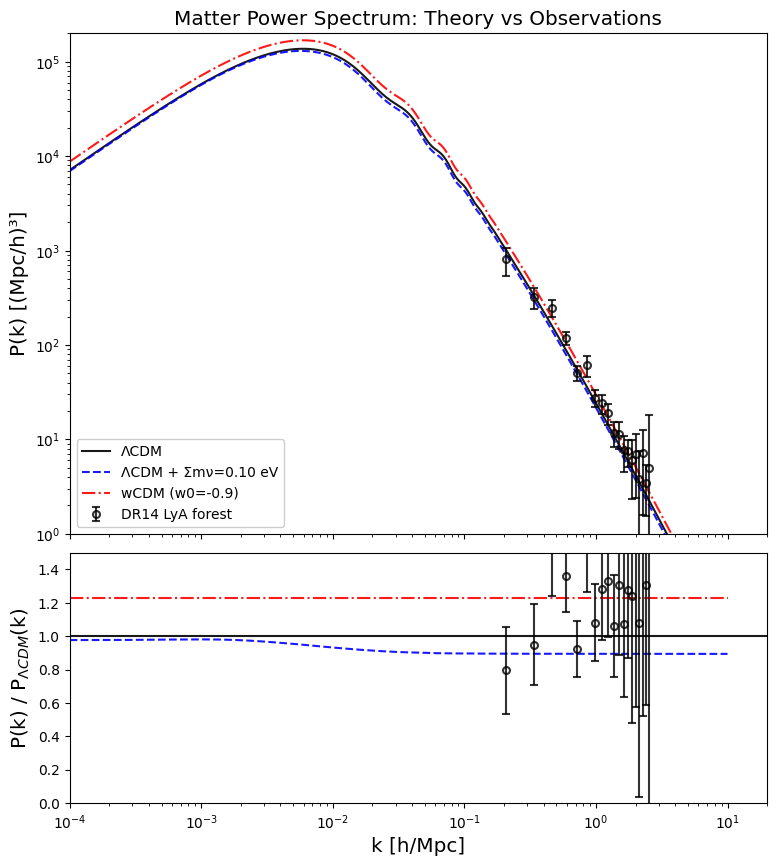

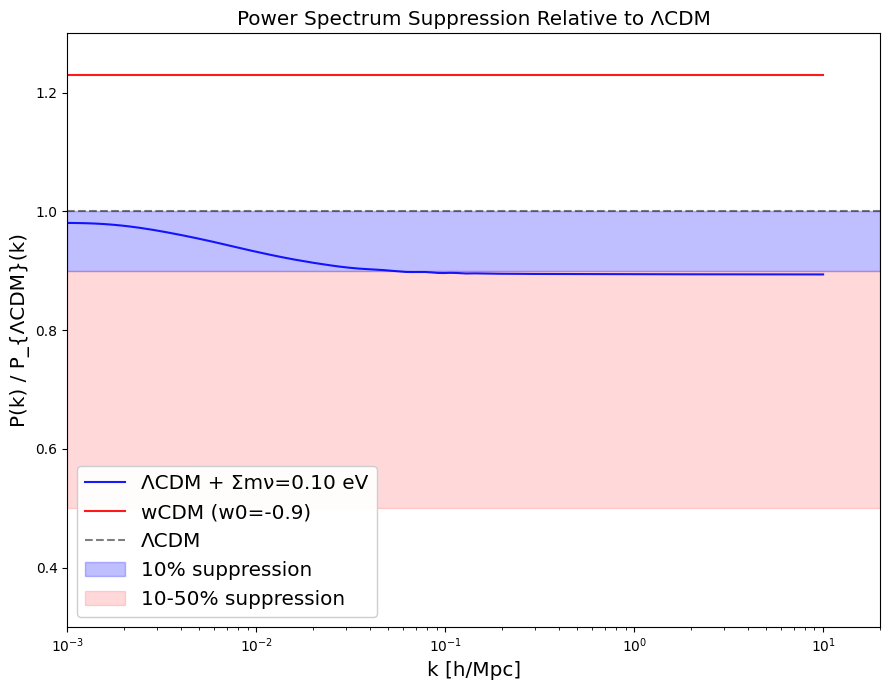

In [14]:
query = """
Using the observational data from eBOSS DR14 Lyman-alpha forest (data/DR14_pm3d_19kbins.txt), 
compare the linear P(k) values for ΛCDM, ΛCDM with massive neutrinos (Σmν=0.10 eV), and dark 
energy model with equation of state parameter w0=-0.9. 

Create visualizations showing:
1. The power spectra comparison with observational data
2. The suppression ratios relative to ΛCDM

Comment on how close the P(k) values are and analyze the power spectrum suppression compared to ΛCDM.
"""

result = orchestrator.run(query)

## Evaluation

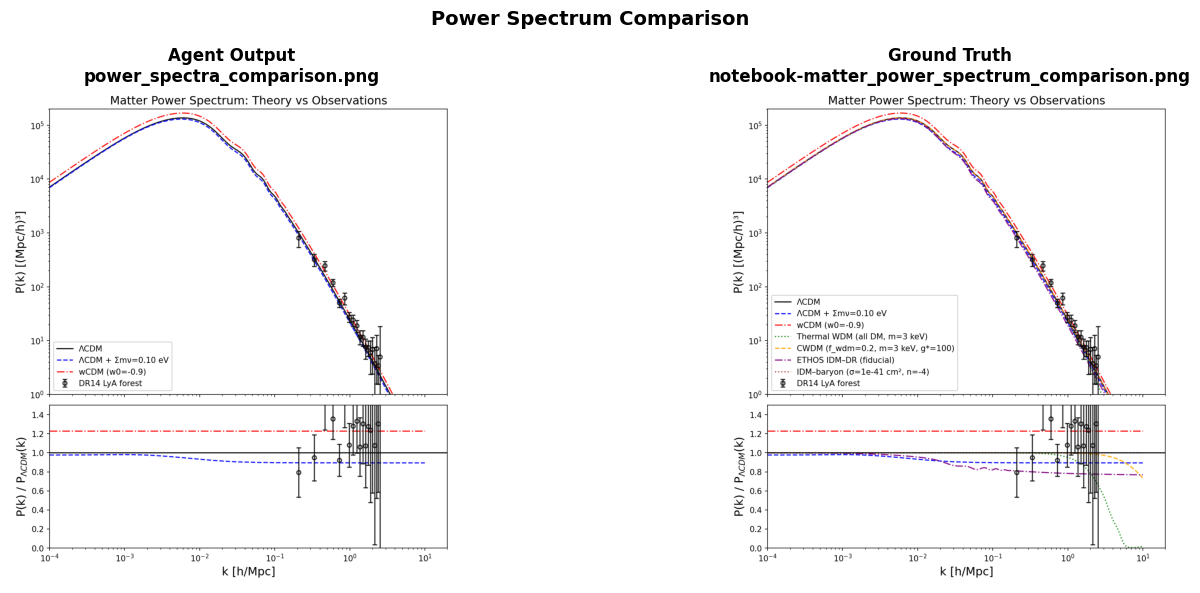

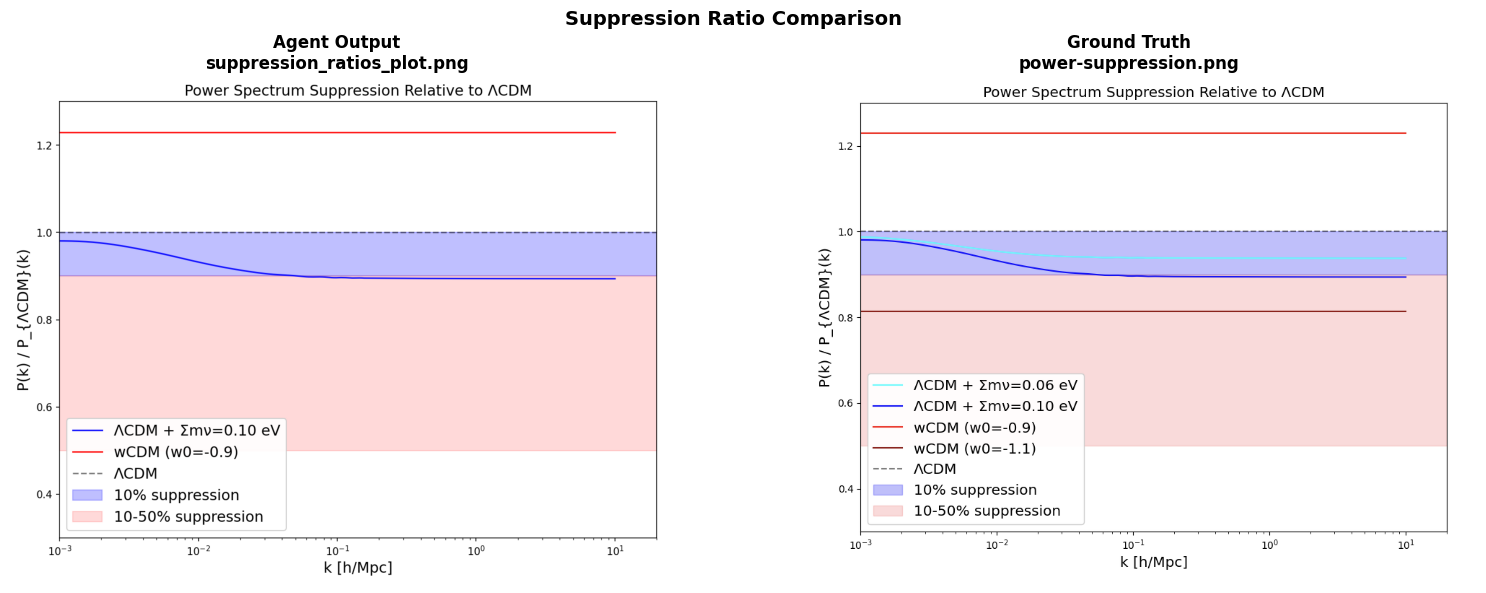

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os

# Find power spectrum plots
agent_power = sorted(glob.glob(f'{AGENTS_OUT_DIR}/*power*.png'))
ground_power = sorted(glob.glob('ground-truth/*power*.png'))

# Find suppression ratio plots
agent_suppression = sorted(glob.glob(f'{AGENTS_OUT_DIR}/*suppression*.png'))
ground_suppression = sorted(glob.glob('ground-truth/*suppression*.png'))

# Helper function to display side-by-side comparison
def display_comparison(agent_path, ground_path, title):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left panel: Agent output
    if agent_path and os.path.exists(agent_path):
        img_agent = mpimg.imread(agent_path)
        axes[0].imshow(img_agent)
        axes[0].set_title(f'Agent Output\n{os.path.basename(agent_path)}', fontsize=12, fontweight='bold')
        axes[0].axis('off')
    else:
        axes[0].text(0.5, 0.5, 'No agent output found', ha='center', va='center', fontsize=14)
        axes[0].set_title('Agent Output', fontsize=12, fontweight='bold')
        axes[0].axis('off')
    
    # Right panel: Ground truth
    if ground_path and os.path.exists(ground_path):
        img_ground = mpimg.imread(ground_path)
        axes[1].imshow(img_ground)
        axes[1].set_title(f'Ground Truth\n{os.path.basename(ground_path)}', fontsize=12, fontweight='bold')
        axes[1].axis('off')
    else:
        axes[1].text(0.5, 0.5, 'No ground truth found', ha='center', va='center', fontsize=14)
        axes[1].set_title('Ground Truth', fontsize=12, fontweight='bold')
        axes[1].axis('off')
    
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

if agent_power or ground_power:
    agent_p = agent_power[0] if agent_power else None
    ground_p = ground_power[0] if ground_power else None
    display_comparison(agent_p, ground_p, 'Power Spectrum Comparison')
else:
    print("No power spectrum plots found in either directory.")

print("\n")

if agent_suppression or ground_suppression:
    agent_s = agent_suppression[0] if agent_suppression else None
    ground_s = ground_suppression[0] if ground_suppression else None
    display_comparison(agent_s, ground_s, 'Suppression Ratio Comparison')
else:
    print("No suppression ratio plots found in either directory.")

## Custom Queries

Try your own queries below:

In [16]:
# custom_query = """ """

# custom_result = orchestrator.run(custom_query)
# print(custom_result)